In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

/Users/jakefloch/Documents/GitHub/techbridge24/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#ae = pd.read_excel('..\data\Sample Data AgencyExpress (1% sample Georgia).xlsx')
amx_lines = pd.read_excel('../Choice Data.xlsx', sheet_name='AMX_OFFER_LINES')
amx_header = pd.read_excel('../Choice Data.xlsx', sheet_name='AMX_OFFER_HEADER')

In [3]:
sp500 = pd.read_csv('../SP500.csv')

In [4]:
amx_lines = amx_lines[['OFFERNUMBER', 'PRODUCTTYPECODE', 'QUANTITY', 'TOTALGROSSWEIGHT']]
print(amx_lines.shape)
amx_header = amx_header[['OFFERNUMBER', 'OFFERDATE']]
print(amx_header.shape)

(359978, 4)
(46509, 2)


In [5]:
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])
#sp500['QUARTER_YEAR'] = sp500['observation_date'].dt.to_period('Q')
display(sp500)

,observation_date,SP500
0,2015-04-20,2100.40
1,2015-04-21,2097.29
2,2015-04-22,2107.96
3,2015-04-23,2112.93
4,2015-04-24,2117.69
...,...,...
2604,2025-04-11,5363.36
2605,2025-04-14,5405.97
2606,2025-04-15,5396.63
2607,2025-04-16,5275.70


In [6]:
amx = pd.merge(amx_lines, amx_header, on='OFFERNUMBER')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
0,N059273,BP,21.0,493.50,04/10/2003
1,N059274,COND,231.0,2852.85,04/10/2003
2,N060118,BP,12.0,60.00,04/21/2003
3,N060118,BP,24.0,120.00,04/21/2003
4,N052341,MIX,1441.0,10040.00,02/19/2003
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,10/15/2024
359943,N26060401,MEAT,20.0,552.96,10/15/2024
359944,N26060401,DSRT,201.0,660.29,10/15/2024
359945,N26060401,MEAT,30.0,62.22,10/15/2024


In [7]:
amx['OFFERDATE'] = pd.to_datetime(amx['OFFERDATE'])
amx = amx[amx['OFFERDATE'].dt.year >= 2015]
#amx['QUARTER_YEAR'] = amx['OFFERDATE'].dt.to_period('Q')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
135627,N6167646,BABY,68.0,394.00,2015-02-26
135628,N6167646,BABY,1265.0,4630.00,2015-02-26
135629,N6167646,BABY,3.0,9.00,2015-02-26
135630,N6167646,BABY,29.0,98.00,2015-02-26
135631,N6167646,BABY,60.0,121.00,2015-02-26
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,2024-10-15
359943,N26060401,MEAT,20.0,552.96,2024-10-15
359944,N26060401,DSRT,201.0,660.29,2024-10-15
359945,N26060401,MEAT,30.0,62.22,2024-10-15


In [8]:
amx_grouped = amx.groupby([pd.Grouper(key='OFFERDATE', freq='W'), 'PRODUCTTYPECODE'])['QUANTITY'].sum().reset_index()

amx_pivot = amx_grouped.pivot(index='OFFERDATE', columns='PRODUCTTYPECODE', values='QUANTITY').fillna(0)

display(amx_pivot)

PRODUCTTYPECODE,BABY,BEV,BP,CEREAL,CLEAN,COND,DAIRY,DOUGH,DRESS,DSRT,...,PASTA,PET,PHSE,PPERS,PREPERISH,PRO,RICE,SALVAGE,SNACK,VEG
OFFERDATE,,,,,,,,,,,,,,,,,,,,,
2015-01-11,3664.0,1485.0,44.0,86.0,0.0,0.0,173.0,0.0,590.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1164.0,40.0
2015-01-18,0.0,0.0,0.0,0.0,0.0,653.0,972.0,0.0,1515.0,0.0,...,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,39116.0,0.0
2015-01-25,0.0,6967.0,984.0,10730.0,0.0,57.0,49.0,0.0,0.0,7.0,...,320.0,0.0,0.0,2.0,0.0,644.0,0.0,0.0,26441.0,0.0
2015-02-01,7031.0,7475.0,164.0,8764.0,0.0,593.0,5096.0,0.0,276.0,3489.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,576.0,36507.0,2.0
2015-02-08,0.0,2724.0,672.0,2407.0,0.0,681.0,78.0,0.0,103.0,6565.0,...,0.0,0.0,0.0,0.0,0.0,18743.0,0.0,0.0,2756.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-22,0.0,138.0,0.0,0.0,0.0,109.0,552.0,0.0,171.0,144.0,...,2698.0,2728.0,0.0,0.0,0.0,0.0,2739.0,24.0,4309.0,20948.0
2024-09-29,1470.0,18.0,2.0,0.0,0.0,971.0,166.0,1275.0,216.0,302.0,...,0.0,14353.0,0.0,0.0,0.0,264.0,0.0,0.0,2363.0,10563.0
2024-10-06,2240.0,274.0,893.0,3619.0,0.0,5176.0,7258.0,2336.0,2833.0,250.0,...,6548.0,1723.0,0.0,0.0,0.0,305.0,1017.0,0.0,15205.0,4925.0


In [9]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

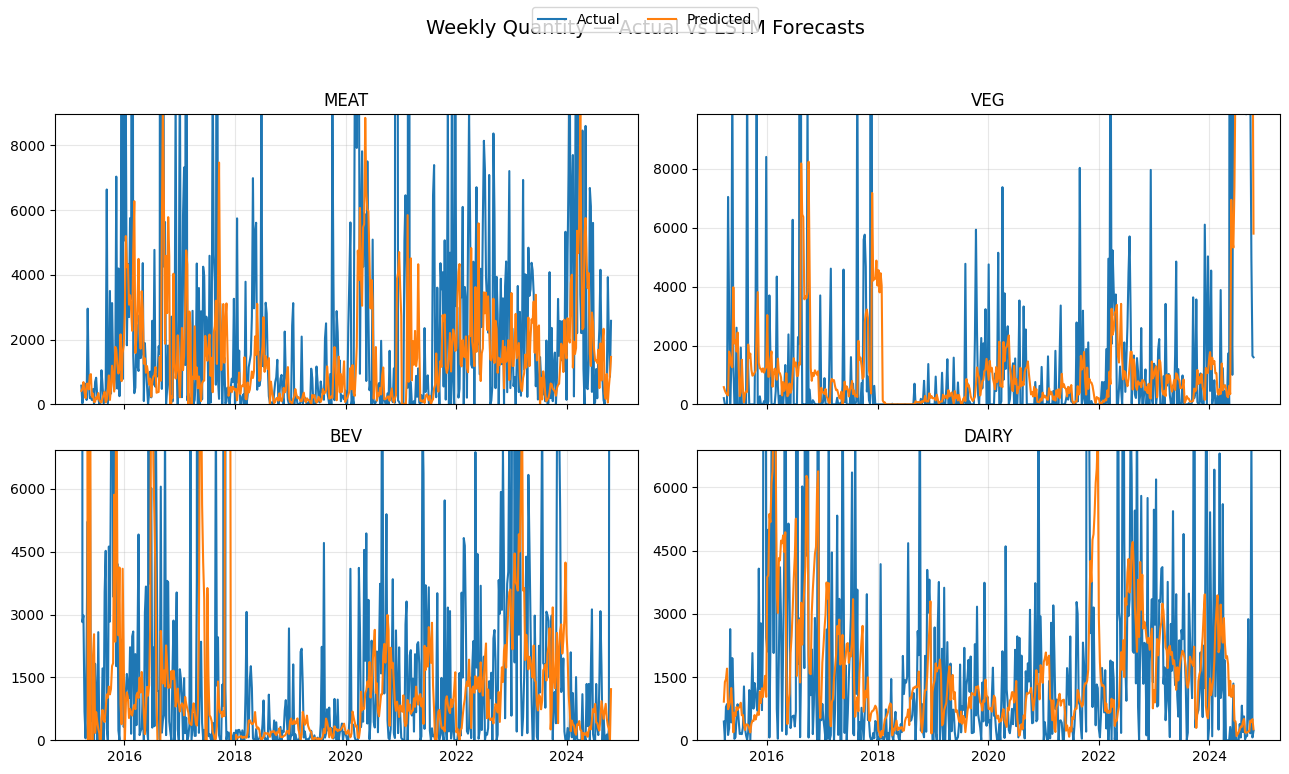

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# ---------------- hyper‑params ----------------
WINDOW, EPOCHS, UNITS = 10, 30, 50
TARGETS               = ['MEAT', 'VEG', 'BEV', 'DAIRY']

# ------------ build empty 2 × 2 grid ----------
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True)
axes = axes.ravel()                 # flatten -> axes[0]..axes[3]

for ax, code in zip(axes, TARGETS):
    if code not in amx_pivot.columns:
        ax.set_visible(False)
        continue

    # ----- data -------------------------------
    series = amx_pivot[code].values
    X, y   = create_sequences(series, WINDOW)
    X      = X.reshape(-1, WINDOW, 1)

    # ----- model ------------------------------
    model = build_model(WINDOW, UNITS)
    model.fit(X, y, epochs=EPOCHS, verbose=0)
    yhat  = model.predict(X, verbose=0).ravel()
    dates = amx_pivot.index[WINDOW:]

    # ----- percentile clip to tame spikes -----
    y_top = np.percentile(y, 95)
    y_bot = max(0, np.percentile(y, 5))
    ax.set_ylim(y_bot, y_top)

    # ----- plotting ---------------------------
    ax.plot(dates, y,    label='Actual')
    ax.plot(dates, yhat, label='Pred.')
    ax.set_title(code)
    ax.yaxis.set_major_locator(mtick.MaxNLocator(5))
    ax.grid(alpha=0.3)

# -------- global formatting -------------------
locator   = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

fig.suptitle('Weekly Quantity — Actual vs LSTM Forecasts', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for big title
fig.legend(['Actual', 'Predicted'], loc='upper center', ncol=2)
fig.savefig('forecast_grid.png', dpi=300)   # high‑res file for slides
plt.show()
